# Set Environment

In [1]:
import os
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

import cv2
import random
from sklearn.model_selection import train_test_split
import pickle
from tqdm.notebook import tqdm

# Set Seed for Reproducibility

In [2]:
def set_seed(seed=21019):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    #os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

# Checking if shapes are consistent

In [3]:
train_dir = ['/kaggle/input/intel-mobileodt-cervical-cancer-screening/train/train/Type_1',
             '/kaggle/input/intel-mobileodt-cervical-cancer-screening/train/train/Type_2',
             '/kaggle/input/intel-mobileodt-cervical-cancer-screening/train/train/Type_3',
             '/kaggle/input/intel-mobileodt-cervical-cancer-screening/additional_Type_1_v2/Type_1',
             '/kaggle/input/intel-mobileodt-cervical-cancer-screening/additional_Type_2_v2/Type_2',
             '/kaggle/input/intel-mobileodt-cervical-cancer-screening/additional_Type_3_v2/Type_3']

df = pd.DataFrame(columns = ['train_dir', 'no_samples', 'random_sample', 'image_shape'])
for path in train_dir:
    files = os.listdir(path)
    no_samples = len(files)
    random_file = random.choice(files)
    image = cv2.imread(os.path.join(path,random_file))
    image_shape = image.shape
    df = df.append({'train_dir':path,
                    'no_samples':no_samples,
                    'random_sample':random_file,
                    'image_shape':image_shape},
                   ignore_index = True)
    
df

,train_dir,no_samples,random_sample,image_shape
0,/kaggle/input/intel-mobileodt-cervical-cancer-...,250,890.jpg,"(4128, 3096, 3)"
1,/kaggle/input/intel-mobileodt-cervical-cancer-...,781,1391.jpg,"(3264, 2448, 3)"
2,/kaggle/input/intel-mobileodt-cervical-cancer-...,450,33.jpg,"(3264, 2448, 3)"
3,/kaggle/input/intel-mobileodt-cervical-cancer-...,1191,6866.jpg,"(4128, 3096, 3)"
4,/kaggle/input/intel-mobileodt-cervical-cancer-...,3567,556.jpg,"(4128, 3096, 3)"
5,/kaggle/input/intel-mobileodt-cervical-cancer-...,1976,1426.jpg,"(4128, 3096, 3)"


**Image shape is inconsistent; needs to be reshaped**

# See Random Samples

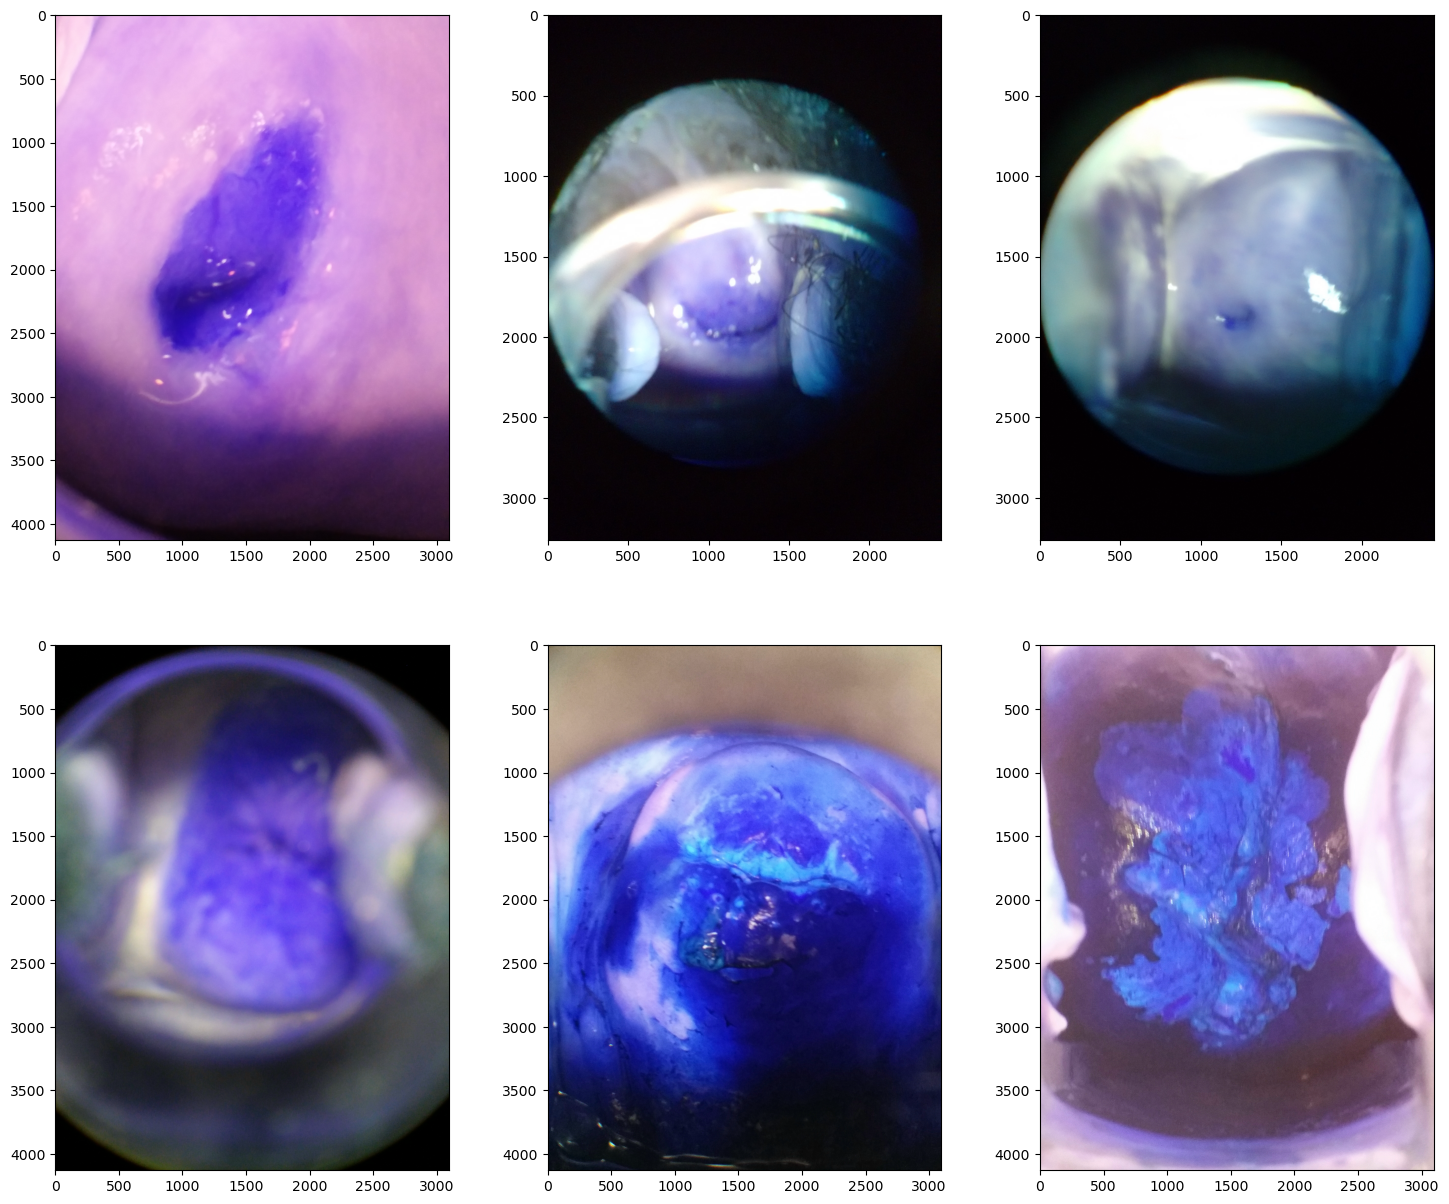

In [4]:
plt.figure(figsize=(18,15))
for i in range(len(df)):
    image = cv2.imread(os.path.join(df['train_dir'][i],df['random_sample'][i]))
    plt.subplot(2, 3, i+1)
    plt.imshow(image)
    
plt.show()

# Generate Dataset

In [5]:
data = []
labels = []
class_names = list(['Type 1','Type 2','Type 3'])
image_size = (227, 227)

l = -1
for path in train_dir:
    files = os.listdir(path)
    l = l + 1
    print(f'Reading files from {path}')
    for i in tqdm(files, desc=f'Processing {path}'):   
        image = cv2.imread(os.path.join(path, i))
        try:
            image = cv2.resize(image, image_size, interpolation=cv2.INTER_AREA)
        except:
            continue
        data.append(image)
        labels.append(l % 3)

X = np.array(data)
y = np.array(labels)

Reading files from /kaggle/input/intel-mobileodt-cervical-cancer-screening/train/train/Type_1


Processing /kaggle/input/intel-mobileodt-cervical-cancer-screening/train/train/Type_1:   0%|          | 0/250 …

Premature end of JPEG file


Reading files from /kaggle/input/intel-mobileodt-cervical-cancer-screening/train/train/Type_2


Processing /kaggle/input/intel-mobileodt-cervical-cancer-screening/train/train/Type_2:   0%|          | 0/781 …

Reading files from /kaggle/input/intel-mobileodt-cervical-cancer-screening/train/train/Type_3


Processing /kaggle/input/intel-mobileodt-cervical-cancer-screening/train/train/Type_3:   0%|          | 0/450 …

Reading files from /kaggle/input/intel-mobileodt-cervical-cancer-screening/additional_Type_1_v2/Type_1


Processing /kaggle/input/intel-mobileodt-cervical-cancer-screening/additional_Type_1_v2/Type_1:   0%|         …

Premature end of JPEG file


Reading files from /kaggle/input/intel-mobileodt-cervical-cancer-screening/additional_Type_2_v2/Type_2


Processing /kaggle/input/intel-mobileodt-cervical-cancer-screening/additional_Type_2_v2/Type_2:   0%|         …

Premature end of JPEG file


Reading files from /kaggle/input/intel-mobileodt-cervical-cancer-screening/additional_Type_3_v2/Type_3


Processing /kaggle/input/intel-mobileodt-cervical-cancer-screening/additional_Type_3_v2/Type_3:   0%|         …

In [6]:
# Check for consistency in data and label shapes and file counts
print(f'Dataset Shape: {X.shape}, Labels Shape: {y.shape}')
t1 = np.count_nonzero(y==0)
print(f'Type 1 Samples: {t1}')
t2 = np.count_nonzero(y==1)
print(f'Type 2 Samples: {t2}')
t3 = np.count_nonzero(y==2)
print(f'Type 3 Samples: {t3}')

no_dropped = df['no_samples'].sum() - t1 - t2 - t3
print(f'Samples dropped due to reshaping error: {no_dropped}')

Dataset Shape: (8212, 227, 227, 3), Labels Shape: (8212,)
Type 1 Samples: 1440
Type 2 Samples: 4346
Type 3 Samples: 2426
Samples dropped due to reshaping error: 3


# Train-Validation-Test Split

In [7]:
# Perform train-test split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

# Perform train-validation split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=19)
# Change random_state value for a different split

print(f'Samples in Train Set: {len(y_train)}')
print(f'Samples in Validation Set: {len(y_val)}')
print(f'Samples in Test Set: {len(y_test)}')

Samples in Train Set: 4926
Samples in Validation Set: 1643
Samples in Test Set: 1643


# Save split sets for reproduction

In [8]:
splits = {
    'x_train': x_train,
    'x_val': x_val,
    'x_test': x_test,
    'y_train': y_train,
    'y_val': y_val,
    'y_test': y_test
}

with open('data_splits_for_cyenet.pkl', 'wb') as f:
    pickle.dump(splits, f)

# Code for loading data in your notebook from the saved pickle file

In [9]:
#with open('data_splits_for_cyenet.pkl', 'rb') as f:
#    loaded_splits = pickle.load(f)

#x_train = loaded_splits['x_train']
#x_val = loaded_splits['x_val']
#x_test = loaded_splits['x_test']
#y_train = loaded_splits['y_train']
#y_val = loaded_splits['y_val']
#y_test = loaded_splits['y_test']